In [1]:
bmshj2018="D:\\Dataset\\Compression\\Source_Data\\bmshj2018\\dataset_d04_mini_unzipped.nc"
cheng2020="D:\\Dataset\\Compression\\Source_Data\\cheng2020_anchor\\dataset_d04_mini_unzipped.nc"
zfpy="D:\\Dataset\\Compression\\Source_Data\\ZFPY_12\\dataset_d04_mini_unzipped.nc"
mbt2018="D:\\Dataset\\Compression\\Source_Data\\mbt2018\\dataset_d04_mini_unzipped.nc"
sz3="D:\\Dataset\\Compression\\Source_Data\\SZ3\\dataset_d04_mini_unzipped.nc"
original="D:\\Dataset\\Compression\\Source_Data\\dataset_d04_mini.nc"








# Study Area Analysis

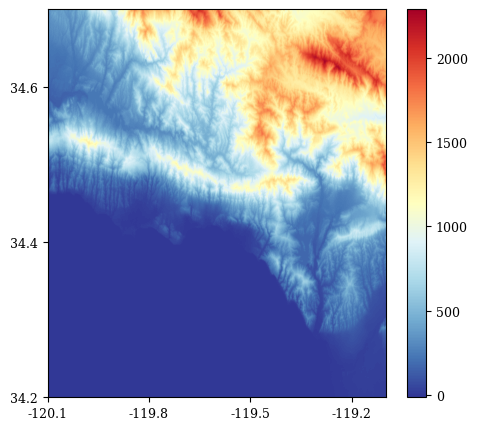

Elevation data shape: (1800, 3600)


In [95]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

# Read the SRTM elevation data
srtm_path = "D:\\Dataset\\Compression\\Source_Data\\output_SRTMGL1.tif"
with rasterio.open(srtm_path) as src:
    elevation = src.read(1)  # Read as numpy array
    bounds = src.bounds
    
    # Get the extent for proper lat/lon plotting
    left, bottom, right, top = bounds

# Set plot style
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.labelsize': 13,
    'axes.titlesize': 13
})

# Create new figure
fig = plt.figure(figsize=(5, 4.5))
ax = plt.subplot(111)

# Display data with proper lat/lon extent
im = ax.imshow(elevation,
               extent=[left, right, bottom, top],
               cmap='RdYlBu_r',
               aspect='auto')

# Set x and y ticks with specified intervals, formatted to 1 decimal place
ax.set_xticks(np.arange(left, right, 0.3))
ax.set_yticks(np.arange(bottom, top, 0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

# Add colorbar
cbar = plt.colorbar(im)

# Set title and axis labels
plt.tight_layout()
plt.show()

# Print data shape for reference
print(f"Elevation data shape: {elevation.shape}")




# Spatial Analysis

C:\Users\isxzl\AppData\Local\Temp\ipykernel_25872\3199769038.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


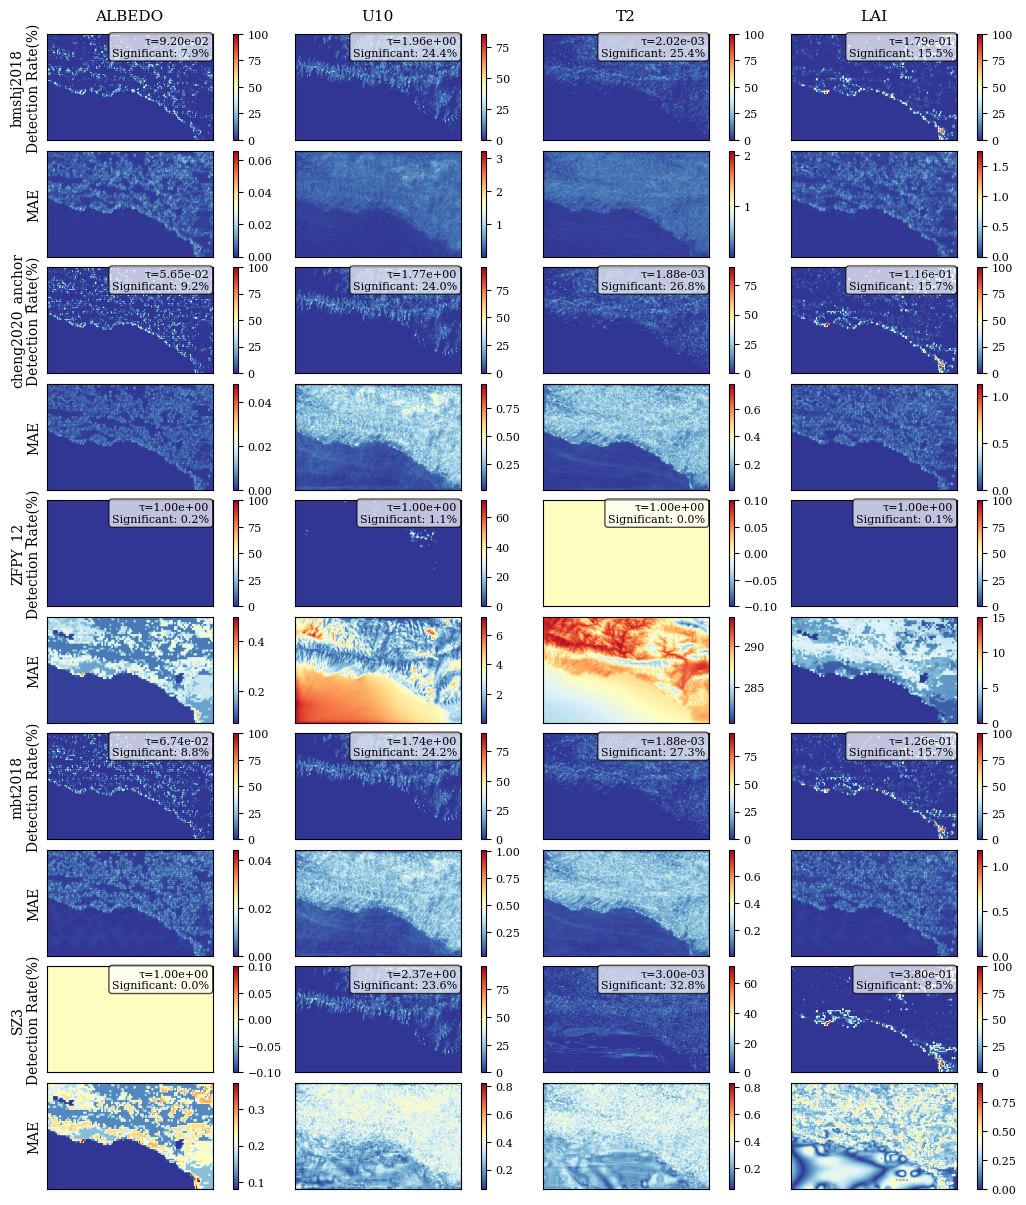

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

# Set style for academic aesthetic
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': False,
    'axes.spines.top': True,
    'axes.spines.right': True,
})

# Define variables and models
ALBEDO = "ALBEDO"
LAI = "LAI" 
U10 = "U10"
T2 = "T2"

var_list = [ALBEDO, U10, T2, LAI]
model_list = [bmshj2018, cheng2020, zfpy, mbt2018, sz3]

# Create figure with GridSpec
n_vars = len(var_list)
n_models = len(model_list)
fig = plt.figure(figsize=(4*n_vars, 3*n_models))
gs = GridSpec(n_models*2, n_vars, figure=fig, hspace=0.1, wspace=-0.5)

# Plot for each model and variable
for i, model in enumerate(model_list):
    for j, var in enumerate(var_list):
        # Get data for model and variable
        ds_model = xr.open_dataset(model)
        ds_orig = xr.open_dataset(original)
        
        data_model = ds_model[var].values
        data_orig = ds_orig[var].values
        
        # Calculate relative errors across all timesteps
        # When data_orig is 0, divide by the mean instead
        data_orig_mean = np.mean(data_orig[data_orig != 0])
        rel_errors = np.abs(data_model - data_orig) / np.where(data_orig == 0, data_orig_mean, np.abs(data_orig))
        
        # Calculate 99th percentile threshold of relative error
        threshold = np.percentile(rel_errors, 97.5)
        
        # Calculate error detection rate for each grid cell
        detection_rates = np.mean(rel_errors > threshold, axis=0) * 100
        
        # Calculate mean absolute error for second row plot
        mean_abs_error = np.mean(np.abs(data_model - data_orig), axis=0)
        
        # Calculate significant pixels (detection rate > 2%)
        significant_ratio = np.mean(detection_rates > 1) * 100
        
        # Plot relative error detection rates
        ax1 = fig.add_subplot(gs[i*2, j])
        im1 = ax1.imshow(detection_rates, cmap='RdYlBu_r', aspect='equal', origin='lower')
        cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
        cbar1.ax.tick_params(labelsize=8)
        
        # Add semi-transparent text box with threshold and significant ratio
        textstr = f'τ={threshold:.2e}\nSignificant: {significant_ratio:.1f}%'
        props = dict(boxstyle='round', facecolor='white', alpha=0.7)
        ax1.text(0.98, 0.98, textstr,
                transform=ax1.transAxes,
                horizontalalignment='right',
                verticalalignment='top',
                fontsize=8,
                bbox=props)
        
        if j == 0:
            model_name = model.split("\\")[-2]
            ax1.set_ylabel(f'{model_name}\nDetection Rate(%)', fontsize=10)
        if i == 0:
            ax1.set_title(var, fontsize=11, pad=10)
        ax1.set_xticks([])
        ax1.set_yticks([])
            
        # Plot mean absolute error
        ax2 = fig.add_subplot(gs[i*2+1, j])
        im2 = ax2.imshow(mean_abs_error, cmap='RdYlBu_r', aspect='equal', origin='lower')
        cbar2 = plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)
        cbar2.ax.tick_params(labelsize=8)
        
        if j == 0:
            ax2.set_ylabel('MAE', fontsize=10)
        ax2.set_xticks([])
        ax2.set_yticks([])
plt.tight_layout()
plt.show()


# Time series Analysis

100%|██████████| 3/3 [00:09<00:00,  3.32s/it]
/home/zhehao/anaconda3/envs/compressAI/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


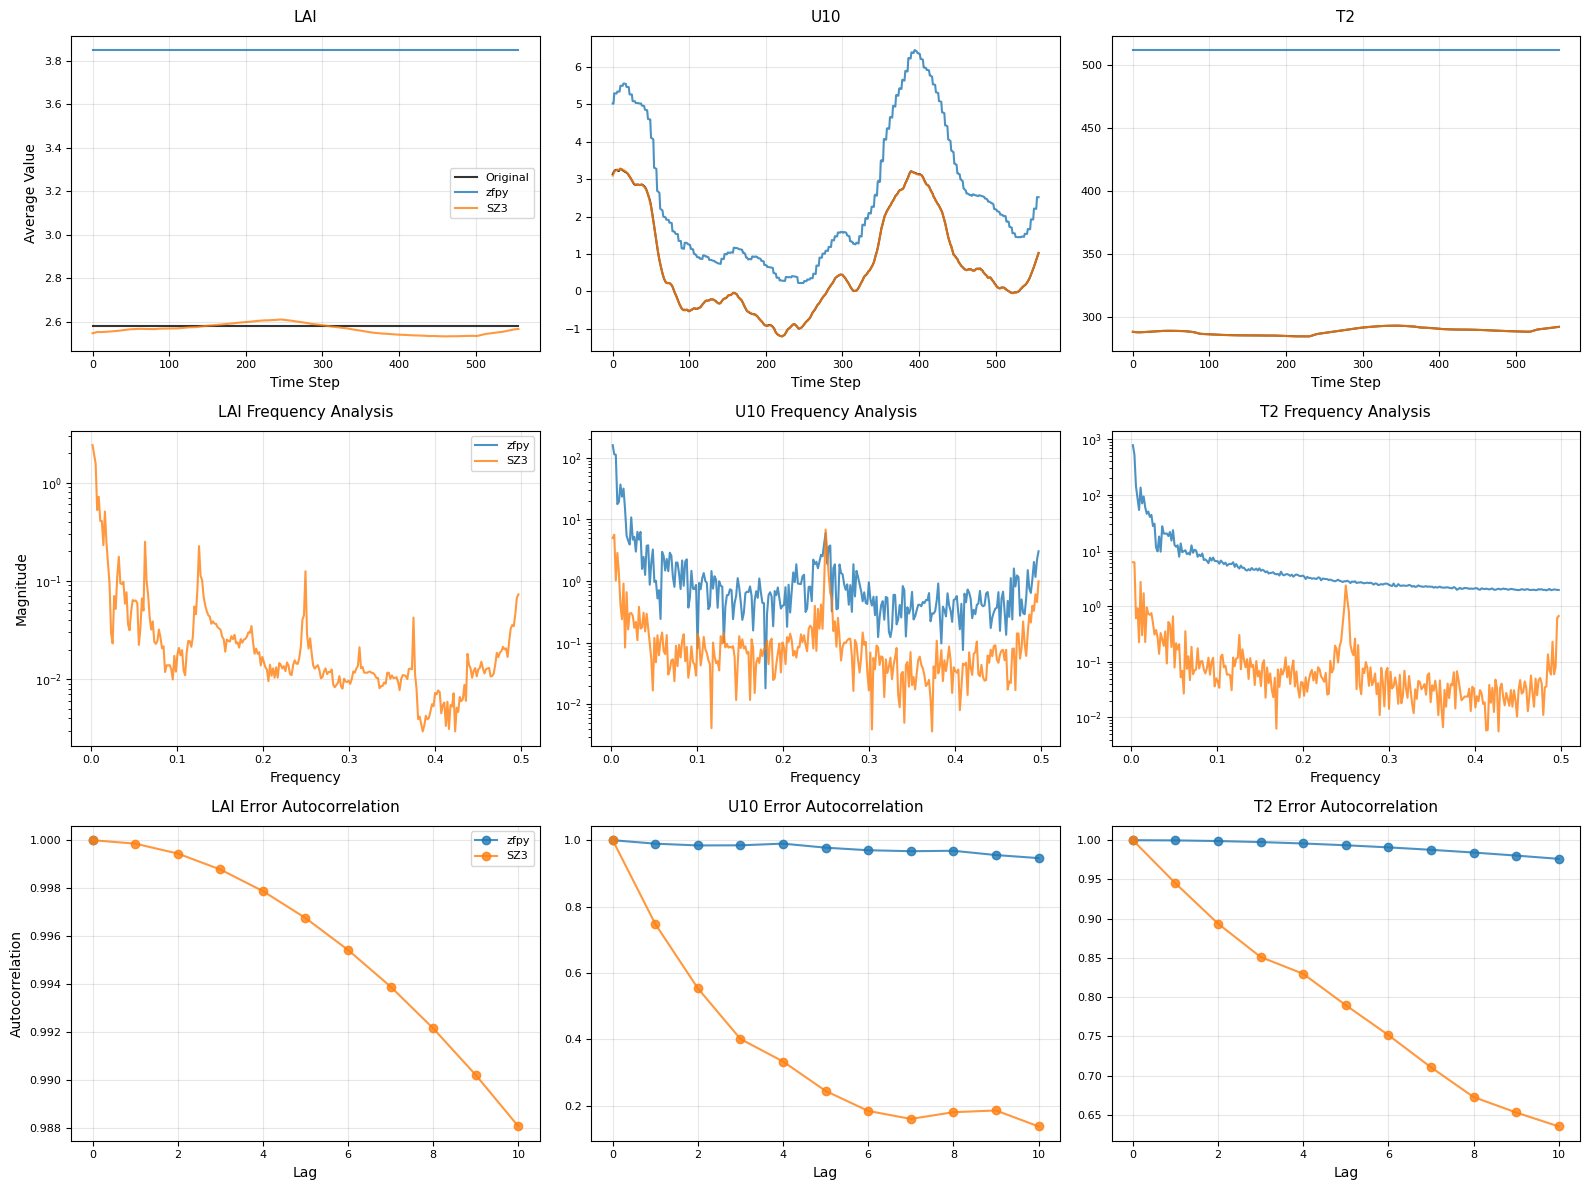

In [20]:
# Define paths based on OS
import os

if os.name == 'nt':  # Windows
    bmshj2018="D:\\Dataset\\Compression\\Source_Data\\bmshj2018\\dataset_d04_mini_unzipped.nc"
    cheng2020="D:\\Dataset\\Compression\\Source_Data\\cheng2020_anchor\\dataset_d04_mini_unzipped.nc"
    zfpy="D:\\Dataset\\Compression\\Source_Data\\ZFPY_12\\dataset_d04_mini_unzipped.nc"
    mbt2018="D:\\Dataset\\Compression\\Source_Data\\mbt2018\\dataset_d04_mini_unzipped.nc"
    sz3="D:\\Dataset\\Compression\\Source_Data\\SZ3\\dataset_d04_mini_unzipped.nc"
    original="D:\\Dataset\\Compression\\Source_Data\\dataset_d04_mini.nc"
else:  # Linux/Unix
    bmshj2018="/media/zhehao/Data/Dataset/Compression/Original/bmshj2018/dataset_d04_unzipped.nc"
    cheng2020="/media/zhehao/Data/Dataset/Compression/Source_Data/cheng2020_anchor/dataset_d04_mini_unzipped.nc"
    zfpy="/media/zhehao/Data/Dataset/Compression/Original/zfpy/dataset_d04_unzipped.nc"
    mbt2018="/media/zhehao/Data/Dataset/Compression/Source_Data/mbt2018/dataset_d04_mini_unzipped.nc"
    sz3="/media/zhehao/Data/Dataset/Compression/Original/SZ3/dataset_d04_unzipped.nc"
    original="/media/zhehao/Data/Dataset/Compression/Original/dataset_d04.nc"

# Define variables and models
ALBEDO = "ALBEDO"
LAI = "LAI" 
U10 = "U10"
T2 = "T2"
var_list = [LAI, U10, T2] # LAI
model_list = [zfpy,sz3,bmshj2018] #zfpy, mbt2018,  #
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import netCDF4 as nc
from scipy import fft
from tqdm import tqdm
# Create figure and gridspec for time series, periodicity, and correlation plots
fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, len(var_list), figure=fig)
# Pre-calculate averages for original data
orig_data = {}
orig_avgs = {}
model_data = {}
model_avgs = {}

for var in tqdm(var_list):
    # Get original data
    with nc.Dataset(original) as ds:
        data = ds[var][:]
        orig_data[var] = data
        orig_avgs[var] = np.mean(data, axis=(1,2))[10:-10]
    
    # Get model data for this variable
    for model_path in model_list:
        if model_path not in model_data:
            model_data[model_path] = {}
            model_avgs[model_path] = {}
            
        with nc.Dataset(model_path) as ds:
            data = ds[var][:]
            model_data[model_path][var] = data
            model_avgs[model_path][var] = np.mean(data, axis=(1,2))[10:-10]

# Loop through variables
for j, var in enumerate(var_list):
    # First row - Original time series plot
    ax1 = fig.add_subplot(gs[0, j])
    
    # Plot original data
    ax1.plot(orig_avgs[var], label='Original', color='black', alpha=0.8)
    
    # Plot compressed data
    for model_path in model_list:
        method_name = os.path.basename(os.path.dirname(model_path))
        ax1.plot(model_avgs[model_path][var], label=method_name, alpha=0.8)
    
    ax1.set_title(var, fontsize=11, pad=10)
    if j == 0:  # Only show legend on first subplot
        ax1.legend(fontsize=8)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlabel('Time Step', fontsize=10)
    if j == 0:
        ax1.set_ylabel('Average Value', fontsize=10)
    ax1.tick_params(axis='both', labelsize=8)
    
    # Second row - Periodicity analysis
    ax2 = fig.add_subplot(gs[1, j])
    
    for model_path in model_list:
        # Calculate error
        error = np.abs(model_data[model_path][var] - orig_data[var])
        avg_error = np.mean(error, axis=(1,2))[10:-10]
        
        # Calculate FFT
        signal = avg_error - np.mean(avg_error)
        freq = fft.fftfreq(len(signal))
        fft_vals = np.abs(fft.fft(signal))
        
        method_name = os.path.basename(os.path.dirname(model_path))
        ax2.plot(freq[1:len(freq)//2], fft_vals[1:len(freq)//2], 
                label=method_name, alpha=0.8)
    
    ax2.set_title(f'{var} Frequency Analysis', fontsize=11, pad=10)
    if j == 0:
        ax2.legend(fontsize=8)
        ax2.set_ylabel('Magnitude', fontsize=10)
    ax2.set_xlabel('Frequency', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', labelsize=8)
    ax2.set_yscale('log')

    # Third row - Lag correlation analysis
    ax3 = fig.add_subplot(gs[2, j])
    
    for model_path in model_list:
        # Calculate error time series
        error = model_data[model_path][var] - orig_data[var]
        error_mean = np.mean(error, axis=(1,2))[10:-10]
        
        # Calculate autocorrelation of error series
        max_lag = 10
        lags = range(0, max_lag+1)
        autocorr = []
        
        for lag in lags:
            if lag == 0:
                corr = 1.0
            else:
                corr = np.corrcoef(error_mean[lag:], error_mean[:-lag])[0,1]
            autocorr.append(corr)
            
        method_name = os.path.basename(os.path.dirname(model_path))
        ax3.plot(lags, autocorr, label=method_name, marker='o', alpha=0.8)
    
    ax3.set_title(f'{var} Error Autocorrelation', fontsize=11, pad=10)
    if j == 0:
        ax3.legend(fontsize=8)
        ax3.set_ylabel('Autocorrelation', fontsize=10)
    ax3.set_xlabel('Lag', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()


# Distribution Analysis

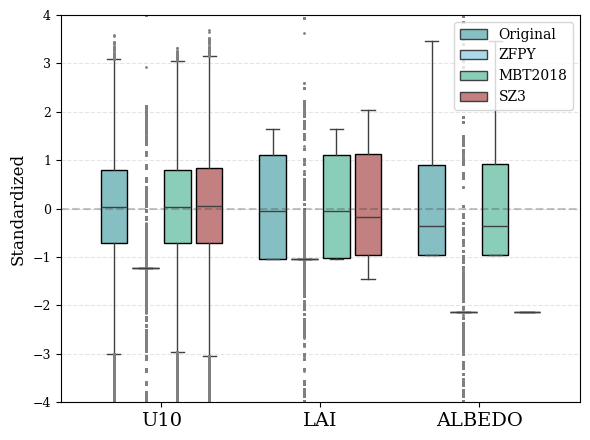

In [57]:
bmshj2018="D:\\Dataset\\Compression\\Source_Data\\bmshj2018\\dataset_d04_mini_unzipped.nc"
cheng2020="D:\\Dataset\\Compression\\Source_Data\\cheng2020_anchor\\dataset_d04_mini_unzipped.nc"
zfpy="D:\\Dataset\\Compression\\Source_Data\\ZFPY_12\\dataset_d04_mini_unzipped.nc"
mbt2018="D:\\Dataset\\Compression\\Source_Data\\mbt2018\\dataset_d04_mini_unzipped.nc"
sz3="D:\\Dataset\\Compression\\Source_Data\\SZ3\\dataset_d04_mini_unzipped.nc"
original="D:\\Dataset\\Compression\\Source_Data\\dataset_d04_mini.nc"

# Define variables and models
ALBEDO = "ALBEDO"
LAI = "LAI" 
U10 = "U10"

var_list = [U10, LAI, ALBEDO]
model_list = [original, zfpy, mbt2018, sz3]

# Create figure for box plots
fig = plt.figure(figsize=(6, 4.5))
ax = fig.add_subplot(111)

data_to_plot = []
labels = []

# Load and prepare data for each variable
for var in var_list:
    var_data = []
    # 首先获取原始数据的均值和标准差
    with nc.Dataset(original) as ds:
        original_data = ds[var][:].flatten()
        var_mean = np.mean(original_data)
        var_std = np.std(original_data)
    
    # 使用原始数据的均值和标准差来标准化所有数据
    for model_path in model_list:
        with nc.Dataset(model_path) as ds:
            data = ds[var][:].flatten()
            # 使用原始数据的统计量进行标准化
            data = (data - var_mean) / var_std
            var_data.append(data)
    data_to_plot.append(var_data)
 
# Create grouped box plots
num_vars = len(var_list)
num_models = len(model_list)
positions = np.arange(num_vars) * 1.5

# Define sophisticated color palette based on RdYlBu_r
colors = ['#85BFC3',    # Sophisticated blue
          '#abd9e9',    # Light blue
          '#8ACEB9',    # Light orange
          '#C38081']    # Deep red

for j in range(num_vars):
    var_boxes = []
    for i in range(num_models):
        pos = positions[j] + i * 0.3
        bp = ax.boxplot([data_to_plot[j][i]], positions=[pos], 
                       widths=0.25,
                       patch_artist=True,
                       whis=1.5,          
                       flierprops={'marker': 'o',    
                                 'markerfacecolor': '#808080',  # Neutral grey for outliers
                                 'markeredgecolor': '#808080',
                                 'markersize': 1},
                       medianprops={'color': '#404040'})  # Darker grey for median lines
        
        # Apply sophisticated colors
        plt.setp(bp['boxes'], facecolor=colors[i], alpha=1)
        plt.setp(bp['whiskers'], color='#404040')  # Darker grey for whiskers
        plt.setp(bp['caps'], color='#404040')      # Darker grey for caps
        var_boxes.append(bp)

# Set the tick labels
tick_positions = positions + (num_models - 1) * 0.3 / 2
plt.xticks(tick_positions, var_list, fontsize=14)

# Add legend with sophisticated colors
legend_elements = [
    plt.Rectangle((0,0),1,1, facecolor=colors[0], alpha=1, edgecolor='#404040', label='Original'),
    plt.Rectangle((0,0),1,1, facecolor=colors[1], alpha=1, edgecolor='#404040', label='ZFPY'),
    plt.Rectangle((0,0),1,1, facecolor=colors[2], alpha=1, edgecolor='#404040', label='MBT2018'),
    plt.Rectangle((0,0),1,1, facecolor=colors[3], alpha=1, edgecolor='#404040', label='SZ3')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.ylabel('Standardized', fontsize=12)

# Add subtle grid
plt.grid(True, axis='y', alpha=0.2, linestyle='--', color='#808080')

# Add horizontal line at y=0
plt.axhline(y=0, color='#404040', linestyle='--', alpha=0.3)
plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

# Bit-wise information content Analysis


ICfilt unique values: [2.93580465e-06 3.03961105e-05 3.39317148e-05 8.25714652e-05
 8.98030105e-05 9.18808257e-05 1.86697244e-04 4.30464111e-04
 5.33887866e-04 1.57200698e-03 1.66099141e-03 2.00786802e-03
 5.27978943e-03 5.90705653e-03 5.98331466e-03 6.55570982e-03
 1.57429949e-02 2.62468151e-02 3.19975472e-02 3.20003760e-02
 3.27676648e-02 3.37563207e-02 3.42012617e-02 3.62215753e-02
 3.94016389e-02 4.47676260e-02 5.53737901e-02 7.11625538e-02
 7.70541434e-02 7.70588682e-02 7.82284645e-02 8.09667775e-02
 8.43688825e-02 8.56161148e-02 9.63673870e-02 9.76888346e-02
 1.17044945e-01 1.18669223e-01 1.45664989e-01 1.55436785e-01
 1.82124627e-01 2.61487897e-01 4.78600044e-01 4.79343318e-01
 4.81833019e-01 4.84718312e-01 1.00000000e+00]


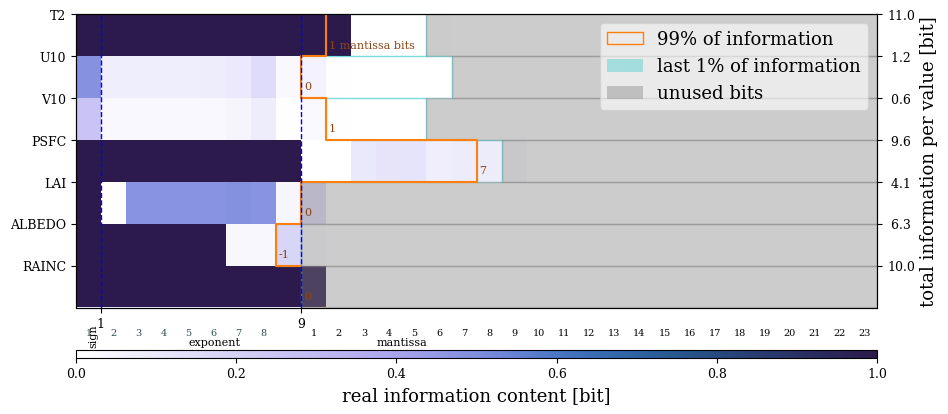

In [195]:
from scipy.stats import entropy, norm
import numpy as np
import warnings
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
def binom_confidence(n: int, c: float) -> float:
    """
    Returns probability p₁ of successes in binomial distribution
    
    Parameters:
    -----------
    n : int
        Number of trials
    c : float
        Confidence level (e.g., 0.99 for 99% confidence)
    """
    p = 0.5 + norm.ppf(1-(1-c)/2)/(2*np.sqrt(n))
    return min(1.0, p)

def binom_free_entropy(n: int, c: float, base: float=2) -> float:
    """
    Returns the free entropy Hf associated with binom_confidence
    
    Parameters:
    -----------
    n : int
        Number of trials
    c : float
        Confidence level
    base : float
        Base for entropy calculation (default=2)
    """
    p = binom_confidence(n, c)
    return 1 - entropy([p, 1-p], base=base)

def analyze_bit_information(da):
    """
    Analyzes the bitwise information content of a DataArray
    
    Parameters:
    -----------
    da : xarray.DataArray
        Input data array
    
    Returns:
    --------
    information : numpy.ndarray
        Array of information content for each bit
    """
    # Data validation
    if not np.isfinite(da.values).all():
        warnings.warn("Data contains non-finite values")
    
    # Ensure 32-bit float
    if da.values.dtype != np.float32:
        da = da.astype(np.float32)
    
    # Get binary representation using big-endian byte order
    binary = da.values.astype('>f4').tobytes()
    binary = np.frombuffer(binary, dtype=np.uint8)
    bit_counts = np.unpackbits(binary).reshape(-1, 32)
    
    # Calculate probabilities and information content
    probabilities = bit_counts.mean(axis=0)
    information = 1 - entropy([probabilities, 1-probabilities], base=2)
    
    # Calculate significance threshold
    n_elements = np.prod(da.shape)
    M = binom_free_entropy(n_elements, 0.99)  # 99% confidence
    
    # Filter insignificant information (mantissa bits only)
    threshold = max(M, 1.5*np.max(information[-4:]))  # Use max of last 4 bits
    insignificant = (information <= threshold) & (np.arange(32) > 9)
    information[insignificant] = 1e-300  # Small positive number for log scale
    
    return information


def plot_bit_information(ds):
    """
    Creates visualization of bitwise information content for an xarray Dataset
    """
    # Calculate bit information for each variable
    bit_info = {}
    nvars = len(ds.data_vars)
    
    # Calculate and filter information content
    ICfilt = np.zeros((nvars, 32))
    for i, var in enumerate(ds.data_vars):
        ic = analyze_bit_information(ds[var])
        
        # Calculate threshold similar to Julia version
        n_elements = np.prod(ds[var].shape)
        p = binom_confidence(n_elements, 0.99)
        M0 = 1 - entropy([p, 1-p], base=2)  # Changed M₀ to M0
        threshold = max(M0, 1.5*np.max(ic[-4:]))
        
        # Filter insignificant bits (mantissa only)
        insignificant = (ic <= threshold) & (np.arange(32) > 9)
        ic[insignificant] = np.finfo(float).tiny
        ICfilt[i, :] = ic
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.invert_yaxis()
    plt.tight_layout(rect=[0.07, 0.08, 0.95, 0.98])
    pos = ax1.get_position()
    
    # Add colorbar axes
    cax = fig.add_axes([pos.x0, 0.06, pos.x1-pos.x0, 0.02])
    
    # Create twin axes for additional information
    ax1right = ax1.twinx()
    ax1right.invert_yaxis()
    
    # Calculate cumulative information
    ICcsum = np.cumsum(ICfilt, axis=1)
    
    # Calculate 99% and 100% information thresholds
    infbits = np.zeros(nvars)
    infbits100 = np.zeros(nvars)
    for i in range(nvars):
        total_info = ICcsum[i, -1]
        infbits[i] = np.where(ICcsum[i, :] >= 0.99 * total_info)[0][0]
        infbits100[i] = np.where(ICcsum[i, :] >= total_info - np.finfo(float).eps)[0][0]
    
    # Plot heatmap with masked data for better visualization
    import cmcrameri.cm as cmc
    ICnan = np.where(ICfilt > np.finfo(float).tiny, ICfilt, np.nan)
    print("ICfilt unique values:", np.unique(ICfilt[ICfilt > np.finfo(float).tiny]))
    pcm = ax1.pcolormesh(ICnan, vmin=0, vmax=1, cmap=cmc.turku_r)
    cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
    cbar.set_label('real information content [bit]')
    
    # Plot 99% information line
    ax1.plot(infbits, np.arange(nvars), 'C1', drawstyle='steps-pre', 
             zorder=10, label='99% of\ninformation')
    
    # Add shading for last 1% information and unused bits
    for i in range(nvars):
        # Grey shading for unused bits (first)

        # Cyan shading for last 1% information (second)
        # ax1.fill_betweenx([i, i+1], 
        #                  [infbits[i], infbits[i]], 
        #                  [infbits100[i], infbits100[i]], 
        #                  alpha=0.1, color='c')
        ax1.fill_betweenx([i, i+1], [infbits100[i], infbits100[i]], [32, 32], 
                         alpha=0.4, color='grey')

        ax1.fill_betweenx([i, i+1], 
                         [infbits[i], infbits[i]], 
                         [infbits100[i], infbits100[i]], 
                         alpha=0.3, facecolor='none', edgecolor='c')
    
    # Set axis limits and labels
    ax1.set_xlim(0, 32)
    ax1.set_ylim(nvars, 0)
    ax1right.set_ylim(nvars, 0)
    
    # Add bit position markers
    ax1.set_xticks([1, 9])
    ax1.axvline(1, color='k', lw=1, zorder=3)
    ax1.axvline(9, color='k', lw=1, zorder=3)
    
    # Add bit type labels
    ax1.text(0, nvars+0.5, "sign", rotation=90)
    ax1.text(2, nvars+0.5, "exponent", rotation=90)
    ax1.text(10, nvars+0.5, "mantissa", rotation=90)
    
    # Set y-axis labels
    ax1.set_yticks(np.arange(nvars))
    ax1right.set_yticks(np.arange(nvars))
    ax1.set_yticklabels(list(ds.data_vars))
    
    # Calculate and display total information per value
    total_info = np.sum(ICfilt, axis=1)
    ax1right.set_yticklabels([f"{x:4.1f}" for x in total_info])
    ax1right.set_ylabel("total information per value [bit]")
    
    # Add bit position numbers
    for i in range(8):
        ax1.text(i+0.5, nvars+0.2, str(i+1), ha='center', va='bottom', 
                fontsize=7, color='darkslategrey')
    for i in range(23):
        ax1.text(i+9.5, nvars+0.2, str(i+1), ha='center', va='bottom', 
                fontsize=7)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, fc='none', ec='C1', label='99% of information'),
        plt.Rectangle((0,0), 1, 1, fc='c', alpha=0.3, label='last 1% of information'),
        plt.Rectangle((0,0), 1, 1, fc='grey', alpha=0.4, label='unused bits')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', framealpha=0.6)
    
    return fig, ax1, ax1right
def plot_bit_information(ds):
    """
    Creates visualization of bitwise information content for an xarray Dataset
    """
    # Calculate bit information for each variable
    bit_info = {}
    nvars = len(ds.data_vars)
    
    # Calculate and filter information content
    ICfilt = np.zeros((nvars, 32))
    for i, var in enumerate(ds.data_vars):
        ic = analyze_bit_information(ds[var])
        
        # Calculate threshold similar to Julia version
        n_elements = np.prod(ds[var].shape)
        p = binom_confidence(n_elements, 0.99)
        M0 = 1 - entropy([p, 1-p], base=2)  # Changed M₀ to M0
        threshold = max(M0, 1.5*np.max(ic[-4:]))
        
        # Filter insignificant bits (mantissa only)
        insignificant = (ic <= threshold) & (np.arange(32) > 9)
        ic[insignificant] = np.finfo(float).tiny
        ICfilt[i, :] = ic
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.invert_yaxis()
    plt.tight_layout(rect=[0.07, 0.08, 0.95, 0.98])
    pos = ax1.get_position()
    
    # Add colorbar axes
    cax = fig.add_axes([pos.x0, 0.06, pos.x1-pos.x0, 0.02])
    
    # Create twin axes for additional information
    ax1right = ax1.twinx()
    ax1right.invert_yaxis()
    
    # Calculate cumulative information
    ICcsum = np.cumsum(ICfilt, axis=1)
    
    # Calculate 99% and 100% information thresholds
    infbits = np.zeros(nvars)
    infbits100 = np.zeros(nvars)
    for i in range(nvars):
        total_info = ICcsum[i, -1]
        infbits[i] = np.where(ICcsum[i, :] >= 0.99 * total_info)[0][0]
        infbits100[i] = np.where(ICcsum[i, :] >= total_info - np.finfo(float).eps)[0][0]
    
    # Plot heatmap with masked data for better visualization
    import cmcrameri.cm as cmc
    ICnan = np.where(ICfilt > np.finfo(float).tiny, ICfilt, np.nan)
    print("ICfilt unique values:", np.unique(ICfilt[ICfilt > np.finfo(float).tiny]))
    pcm = ax1.pcolormesh(ICnan, vmin=0, vmax=1, cmap=cmc.devon_r) #cmc.devon_r
    cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
    cbar.set_label('real information content [bit]')
    
    # Plot 99% information line
    ax1.plot(infbits, np.arange(nvars), 'C1', drawstyle='steps-pre', 
             zorder=10, label='99% of\ninformation')
    
    # Add shading for last 1% information and unused bits
    for i in range(nvars):
        # Grey shading for unused bits (first)
        ax1.fill_betweenx([i, i+1], [infbits100[i], infbits100[i]], [32, 32], 
                         alpha=0.4, color='grey')
        
        # Cyan shading for last 1% information (second)
        ax1.fill_betweenx([i, i+1], 
                         [infbits[i], infbits[i]], 
                         [infbits100[i], infbits100[i]], 
                         alpha=0.3, facecolor='none', edgecolor='c')
    
    # Set axis limits and labels
    ax1.set_xlim(0, 32)
    ax1.set_ylim(nvars, 0)
    ax1right.set_ylim(nvars, 0)
    
    # Add bit position markers
    ax1.set_xticks([1, 9])
    ax1.axvline(1, color='b', lw=1, zorder=10, ls='--')
    ax1.axvline(9, color='b', lw=1, zorder=10, ls='--')
    # Add bit type labels (adjusted positions)
    ax1.text(0.5, nvars+0.9, "sign", rotation=90, fontsize=8)
    ax1.text(4.5, nvars+0.9, "exponent", fontsize=8)
    ax1.text(12, nvars+0.9, "mantissa",  fontsize=8)
    
    # Set y-axis labels
    ax1.set_yticks(np.arange(nvars))
    ax1right.set_yticks(np.arange(nvars))
    ax1.set_yticklabels(list(ds.data_vars))
    
    # Calculate and display total information per value
    total_info = np.sum(ICfilt, axis=1)
    ax1right.set_yticklabels([f"{x:4.1f}" for x in total_info])
    ax1right.set_ylabel("total information per value [bit]")
    
    # Add bit position numbers (adjusted positions)
    for i in range(8):
        ax1.text(i+0.5, nvars+0.7, str(i+1), ha='center', va='bottom', 
                fontsize=7, color='darkslategrey')
    for i in range(23):
        ax1.text(i+9.5, nvars+0.7, str(i+1), ha='center', va='bottom', 
                fontsize=7)
    
    # Add mantissa bits text
    ax1.text(infbits[0]+0.1, 0.8, f"{int(infbits[0]-9)} mantissa bits", 
             fontsize=8, color="saddlebrown")
    for i in range(1, nvars):
        ax1.text(infbits[i]+0.1, i+0.8, f"{int(infbits[i]-9)}", 
                fontsize=8, color="saddlebrown")
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, fc='none', ec='C1', label='99% of information'),
        plt.Rectangle((0,0), 1, 1, fc='c', alpha=0.3, label='last 1% of information'),
        plt.Rectangle((0,0), 1, 1, fc='grey', alpha=0.4, label='unused bits')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', framealpha=0.6)
    
    return fig, ax1, ax1right
import xarray as xr

# Load your dataset
ds = xr.open_dataset(original)



# Create the visualization
fig, ax1, ax1right = plot_bit_information(ds)
plt.show()

Analyzing bit information: 100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


ICfilt unique values: [5.16821019e-08 3.40320156e-07 3.88241961e-07 1.45294290e-06
 1.77710391e-06 3.02101887e-06 5.78916138e-06 6.21142084e-06
 2.21010431e-05 2.38638868e-05 5.44909500e-05 9.08668389e-05
 9.21205310e-05 2.95242083e-04 2.95747978e-04 3.37794683e-04
 3.64204589e-04 3.69741058e-04 3.78219804e-04 4.49835458e-04
 4.64766022e-04 8.06423076e-04 1.21641646e-03 1.33570299e-03
 1.44679036e-03 1.46501997e-03 1.63503230e-03 1.78562423e-03
 1.78705419e-03 1.78705419e-03 1.88397232e-03 3.80702641e-03
 4.80330697e-03 5.78180581e-03 5.89675408e-03 6.07546510e-03
 6.81232722e-03 1.13615565e-02 1.79661465e-02 1.83739821e-02
 2.14107752e-02 2.22565869e-02 2.30473115e-02 2.30498887e-02
 3.10145006e-02 3.62215753e-02 4.52736580e-02 5.32099219e-02
 6.73935933e-02 8.87607959e-02 1.08205810e-01 1.15001486e-01
 1.39188881e-01 1.92326442e-01 5.56776884e-01 5.56807540e-01
 5.64053965e-01 1.00000000e+00]


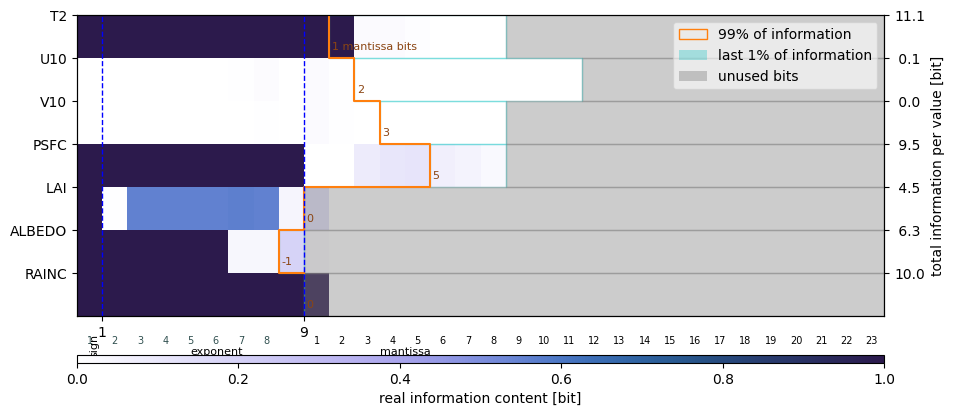

In [5]:
from scipy.stats import entropy, norm
import numpy as np
import warnings
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
def binom_confidence(n: int, c: float) -> float:
    """
    Returns probability p₁ of successes in binomial distribution
    
    Parameters:
    -----------
    n : int
        Number of trials
    c : float
        Confidence level (e.g., 0.99 for 99% confidence)
    """
    p = 0.5 + norm.ppf(1-(1-c)/2)/(2*np.sqrt(n))
    return min(1.0, p)

def binom_free_entropy(n: int, c: float, base: float=2) -> float:
    """
    Returns the free entropy Hf associated with binom_confidence
    
    Parameters:
    -----------
    n : int
        Number of trials
    c : float
        Confidence level
    base : float
        Base for entropy calculation (default=2)
    """
    p = binom_confidence(n, c)
    return 1 - entropy([p, 1-p], base=base)

def analyze_bit_information(da):
    """
    Analyzes the bitwise information content of a DataArray
    
    Parameters:
    -----------
    da : xarray.DataArray
        Input data array
    
    Returns:
    --------
    information : numpy.ndarray
        Array of information content for each bit
    """
    # Data validation
    if not np.isfinite(da.values).all():
        warnings.warn("Data contains non-finite values")
    
    # Ensure 32-bit float
    if da.values.dtype != np.float32:
        da = da.astype(np.float32)
    
    # Get binary representation using big-endian byte order
    binary = da.values.astype('>f4').tobytes()
    binary = np.frombuffer(binary, dtype=np.uint8)
    bit_counts = np.unpackbits(binary).reshape(-1, 32)
    
    # Calculate probabilities and information content
    probabilities = bit_counts.mean(axis=0)
    information = 1 - entropy([probabilities, 1-probabilities], base=2)
    
    # Calculate significance threshold
    n_elements = np.prod(da.shape)
    M = binom_free_entropy(n_elements, 0.99)  # 99% confidence
    
    # Filter insignificant information (mantissa bits only)
    threshold = max(M, 1.5*np.max(information[-4:]))  # Use max of last 4 bits
    insignificant = (information <= threshold) & (np.arange(32) > 9)
    information[insignificant] = 1e-300  # Small positive number for log scale
    
    return information


def plot_bit_information(ds):
    """
    Creates visualization of bitwise information content for an xarray Dataset
    """
    # Calculate bit information for each variable
    bit_info = {}
    nvars = len(ds.data_vars)
    
    # Calculate and filter information content
    ICfilt = np.zeros((nvars, 32))
    for i, var in enumerate(ds.data_vars):
        ic = analyze_bit_information(ds[var])
        
        # Calculate threshold similar to Julia version
        n_elements = np.prod(ds[var].shape)
        p = binom_confidence(n_elements, 0.99)
        M0 = 1 - entropy([p, 1-p], base=2)  # Changed M₀ to M0
        threshold = max(M0, 1.5*np.max(ic[-4:]))
        
        # Filter insignificant bits (mantissa only)
        insignificant = (ic <= threshold) & (np.arange(32) > 9)
        ic[insignificant] = np.finfo(float).tiny
        ICfilt[i, :] = ic
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.invert_yaxis()
    plt.tight_layout(rect=[0.07, 0.08, 0.95, 0.98])
    pos = ax1.get_position()
    
    # Add colorbar axes
    cax = fig.add_axes([pos.x0, 0.06, pos.x1-pos.x0, 0.02])
    
    # Create twin axes for additional information
    ax1right = ax1.twinx()
    ax1right.invert_yaxis()
    
    # Calculate cumulative information
    ICcsum = np.cumsum(ICfilt, axis=1)
    
    # Calculate 99% and 100% information thresholds
    infbits = np.zeros(nvars)
    infbits100 = np.zeros(nvars)
    for i in range(nvars):
        total_info = ICcsum[i, -1]
        infbits[i] = np.where(ICcsum[i, :] >= 0.99 * total_info)[0][0]
        infbits100[i] = np.where(ICcsum[i, :] >= total_info - np.finfo(float).eps)[0][0]
    
    # Plot heatmap with masked data for better visualization
    import cmcrameri.cm as cmc
    ICnan = np.where(ICfilt > np.finfo(float).tiny, ICfilt, np.nan)
    print("ICfilt unique values:", np.unique(ICfilt[ICfilt > np.finfo(float).tiny]))
    pcm = ax1.pcolormesh(ICnan, vmin=0, vmax=1, cmap=cmc.turku_r)
    cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
    cbar.set_label('real information content [bit]')
    
    # Plot 99% information line
    ax1.plot(infbits, np.arange(nvars), 'C1', drawstyle='steps-pre', 
             zorder=10, label='99% of\ninformation')
    
    # Add shading for last 1% information and unused bits
    for i in range(nvars):
        # Grey shading for unused bits (first)

        # Cyan shading for last 1% information (second)
        # ax1.fill_betweenx([i, i+1], 
        #                  [infbits[i], infbits[i]], 
        #                  [infbits100[i], infbits100[i]], 
        #                  alpha=0.1, color='c')
        ax1.fill_betweenx([i, i+1], [infbits100[i], infbits100[i]], [32, 32], 
                         alpha=0.4, color='grey')

        ax1.fill_betweenx([i, i+1], 
                         [infbits[i], infbits[i]], 
                         [infbits100[i], infbits100[i]], 
                         alpha=0.3, facecolor='none', edgecolor='c')
    
    # Set axis limits and labels
    ax1.set_xlim(0, 32)
    ax1.set_ylim(nvars, 0)
    ax1right.set_ylim(nvars, 0)
    
    # Add bit position markers
    ax1.set_xticks([1, 9])
    ax1.axvline(1, color='k', lw=1, zorder=3)
    ax1.axvline(9, color='k', lw=1, zorder=3)
    
    # Add bit type labels
    ax1.text(0, nvars+0.5, "sign", rotation=90)
    ax1.text(2, nvars+0.5, "exponent", rotation=90)
    ax1.text(10, nvars+0.5, "mantissa", rotation=90)
    
    # Set y-axis labels
    ax1.set_yticks(np.arange(nvars))
    ax1right.set_yticks(np.arange(nvars))
    ax1.set_yticklabels(list(ds.data_vars))
    
    # Calculate and display total information per value
    total_info = np.sum(ICfilt, axis=1)
    ax1right.set_yticklabels([f"{x:4.1f}" for x in total_info])
    ax1right.set_ylabel("total information per value [bit]")
    
    # Add bit position numbers
    for i in range(8):
        ax1.text(i+0.5, nvars+0.2, str(i+1), ha='center', va='bottom', 
                fontsize=7, color='darkslategrey')
    for i in range(23):
        ax1.text(i+9.5, nvars+0.2, str(i+1), ha='center', va='bottom', 
                fontsize=7)
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, fc='none', ec='C1', label='99% of information'),
        plt.Rectangle((0,0), 1, 1, fc='c', alpha=0.3, label='last 1% of information'),
        plt.Rectangle((0,0), 1, 1, fc='grey', alpha=0.4, label='unused bits')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', framealpha=0.6)
    
    return fig, ax1, ax1right
def plot_bit_information(ds):
    """
    Creates visualization of bitwise information content for an xarray Dataset
    """
    # Calculate bit information for each variable
    bit_info = {}
    nvars = len(ds.data_vars)
    
    # Calculate and filter information content
    ICfilt = np.zeros((nvars, 32))
    from tqdm import tqdm
    for i, var in tqdm(enumerate(ds.data_vars), total=nvars, desc="Analyzing bit information"):
        ic = analyze_bit_information(ds[var])
        
        # Calculate threshold similar to Julia version
        n_elements = np.prod(ds[var].shape)
        p = binom_confidence(n_elements, 0.99)
        M0 = 1 - entropy([p, 1-p], base=2)  # Changed M₀ to M0
        threshold = max(M0, 1.5*np.max(ic[-4:]))
        
        # Filter insignificant bits (mantissa only)
        insignificant = (ic <= threshold) & (np.arange(32) > 9)
        ic[insignificant] = np.finfo(float).tiny
        ICfilt[i, :] = ic
    
    # Create figure
    fig, ax1 = plt.subplots(figsize=(10, 4))
    ax1.invert_yaxis()
    plt.tight_layout(rect=[0.07, 0.08, 0.95, 0.98])
    pos = ax1.get_position()
    
    # Add colorbar axes
    cax = fig.add_axes([pos.x0, 0.06, pos.x1-pos.x0, 0.02])
    
    # Create twin axes for additional information
    ax1right = ax1.twinx()
    ax1right.invert_yaxis()
    
    # Calculate cumulative information
    ICcsum = np.cumsum(ICfilt, axis=1)
    
    # Calculate 99% and 100% information thresholds
    infbits = np.zeros(nvars)
    infbits100 = np.zeros(nvars)
    for i in range(nvars):
        total_info = ICcsum[i, -1]
        infbits[i] = np.where(ICcsum[i, :] >= 0.99 * total_info)[0][0]
        infbits100[i] = np.where(ICcsum[i, :] >= total_info - np.finfo(float).eps)[0][0]
    
    # Plot heatmap with masked data for better visualization
    import cmcrameri.cm as cmc
    ICnan = np.where(ICfilt > np.finfo(float).tiny, ICfilt, np.nan)
    print("ICfilt unique values:", np.unique(ICfilt[ICfilt > np.finfo(float).tiny]))
    pcm = ax1.pcolormesh(ICnan, vmin=0, vmax=1, cmap=cmc.devon_r) #cmc.devon_r
    cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal')
    cbar.set_label('real information content [bit]')
    
    # Plot 99% information line
    ax1.plot(infbits, np.arange(nvars), 'C1', drawstyle='steps-pre', 
             zorder=10, label='99% of\ninformation')
    
    # Add shading for last 1% information and unused bits
    for i in range(nvars):
        # Grey shading for unused bits (first)
        ax1.fill_betweenx([i, i+1], [infbits100[i], infbits100[i]], [32, 32], 
                         alpha=0.4, color='grey')
        
        # Cyan shading for last 1% information (second)
        ax1.fill_betweenx([i, i+1], 
                         [infbits[i], infbits[i]], 
                         [infbits100[i], infbits100[i]], 
                         alpha=0.3, facecolor='none', edgecolor='c')
    
    # Set axis limits and labels
    ax1.set_xlim(0, 32)
    ax1.set_ylim(nvars, 0)
    ax1right.set_ylim(nvars, 0)
    
    # Add bit position markers
    ax1.set_xticks([1, 9])
    ax1.axvline(1, color='b', lw=1, zorder=10, ls='--')
    ax1.axvline(9, color='b', lw=1, zorder=10, ls='--')
    # Add bit type labels (adjusted positions)
    ax1.text(0.5, nvars+0.9, "sign", rotation=90, fontsize=8)
    ax1.text(4.5, nvars+0.9, "exponent", fontsize=8)
    ax1.text(12, nvars+0.9, "mantissa",  fontsize=8)
    
    # Set y-axis labels
    ax1.set_yticks(np.arange(nvars))
    ax1right.set_yticks(np.arange(nvars))
    ax1.set_yticklabels(list(ds.data_vars))
    
    # Calculate and display total information per value
    total_info = np.sum(ICfilt, axis=1)
    ax1right.set_yticklabels([f"{x:4.1f}" for x in total_info])
    ax1right.set_ylabel("total information per value [bit]")
    
    # Add bit position numbers (adjusted positions)
    for i in range(8):
        ax1.text(i+0.5, nvars+0.7, str(i+1), ha='center', va='bottom', 
                fontsize=7, color='darkslategrey')
    for i in range(23):
        ax1.text(i+9.5, nvars+0.7, str(i+1), ha='center', va='bottom', 
                fontsize=7)
    
    # Add mantissa bits text
    ax1.text(infbits[0]+0.1, 0.8, f"{int(infbits[0]-9)} mantissa bits", 
             fontsize=8, color="saddlebrown")
    for i in range(1, nvars):
        ax1.text(infbits[i]+0.1, i+0.8, f"{int(infbits[i]-9)}", 
                fontsize=8, color="saddlebrown")
    
    # Add legend
    legend_elements = [
        plt.Rectangle((0,0), 1, 1, fc='none', ec='C1', label='99% of information'),
        plt.Rectangle((0,0), 1, 1, fc='c', alpha=0.3, label='last 1% of information'),
        plt.Rectangle((0,0), 1, 1, fc='grey', alpha=0.4, label='unused bits')
    ]
    ax1.legend(handles=legend_elements, loc='upper right', framealpha=0.6)
    
    return fig, ax1, ax1right
import xarray as xr

# Load your dataset
ds = ds2


# Create the visualization
fig, ax1, ax1right = plot_bit_information(ds)
plt.show()

<xarray.Dataset> Size: 103MB
Dimensions:    (time: 21, latitude: 335, longitude: 525)
Coordinates:
  * time       (time) datetime64[ns] 168B 2022-04-03T18:00:00 ... 2022-04-03T...
  * latitude   (latitude) float32 1kB 34.21 34.21 34.21 ... 34.66 34.66 34.66
  * longitude  (longitude) float32 2kB -120.0 -120.0 -120.0 ... -119.2 -119.2
Data variables:
    T2         (time, latitude, longitude) float32 15MB ...
    U10        (time, latitude, longitude) float32 15MB ...
    V10        (time, latitude, longitude) float32 15MB ...
    PSFC       (time, latitude, longitude) float32 15MB ...
    LAI        (time, latitude, longitude) float32 15MB ...
    ALBEDO     (time, latitude, longitude) float32 15MB ...
    RAINC      (time, latitude, longitude) float32 15MB ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.4.1 MODEL
    START_DATE:                      2022-04-03_18:00:00
    SIMULATION_START_DATE:           2022-04-03_18:00:00
    WEST-EAST_GRID_DIMENSION:        526
    SOUTH-NORTH_GRID_DIMENSION:      336
    BOTTOM-TOP_GRID_DIMENSION:       91
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2